# Overview

This is a generalized notebook for computing grade statistics from the Ted Grade Center.

In [1]:
#The usual imports
import math
from collections import OrderedDict

from pandas import read_csv
import numpy as np

from pymatgen.util.plotting_utils import get_publication_quality_plot
from monty.string import remove_non_ascii

import prettyplotlib as ppl
from prettyplotlib import brewer2mpl
import matplotlib.pyplot as plt

colors = brewer2mpl.get_map('Set1', 'qualitative', 8).mpl_colors

%matplotlib inline

Load data from exported CSV from Ted Full Grade Center. Some sanitization is performed to remove non-ascii characters and cruft

In [2]:
d = read_csv("gc_NANO114_WI15_Ong_fullgc_2015-03-16-15-33-52.csv")
d.columns = [remove_non_ascii(c) for c in d.columns]
d.columns = [c.split("[")[0].strip().strip("\"") for c in d.columns]

Define lower grade cutoffs in terms of number of standard deviations from mean.

In [3]:
grade_cutoffs = OrderedDict()
grade_cutoffs["A"] = 0.75
grade_cutoffs["B+"] = 0.5
grade_cutoffs["B"] = -0.25
grade_cutoffs["B-"] = -0.5
grade_cutoffs["C+"] = -0.75
grade_cutoffs["C"] = -1
grade_cutoffs["C-"] = -1.5
grade_cutoffs["F"] = float("-inf")

In [4]:
def bar_plot(dframe, data_key, offset=0):
    """
    Creates a historgram of the results.
    
    Args:
        dframe: DataFrame which is imported from CSV.
        data_key: Specific column to plot
        offset: Allows an offset for each grade. Defaults to 0.
        
    Returns:
        dict of cutoffs, {grade: (lower, upper)}
    """
    data = dframe[data_key]
    d = filter(lambda x: (not np.isnan(x)) and x != 0, list(data))
    heights, bins = np.histogram(d, bins=20, range=(0, 100))
    bins = list(bins)
    bins.pop(-1)
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1)
    ppl.bar(ax, bins, heights, width=5, color=colors[0], grid='y')
    plt = get_publication_quality_plot(12, 8, plt)
    plt.xlabel("Score")
    plt.ylabel("Number of students")
    #print len([d for d in data if d > 90])
    mean = data.mean(0)
    sigma = data.std()
    maxy = np.max(heights)
    prev_cutoff = 100
    cutoffs = {}
    grade = ["A", "B+", "B", "B-", "C+", "C", "C-", "F"]
    for grade, cutoff in grade_cutoffs.items():
        if cutoff == float("-inf"):
            cutoff = 0
        else:
            cutoff = max(0, mean + cutoff * sigma) + offset
            plt.plot([cutoff] * 2, [0, maxy], 'k--')
            plt.annotate("%.1f" % cutoff, [cutoff, maxy - 1], fontsize=18, horizontalalignment='left', rotation=45)
        n = len([d for d in data if cutoff <= d < prev_cutoff])
        print "Grade %s (%.1f-%.1f): %d" % (grade, cutoff, prev_cutoff, n)
        plt.annotate(grade, [(cutoff + prev_cutoff) / 2, maxy], fontsize=18, horizontalalignment='center')
        cutoffs[grade] = (cutoff, prev_cutoff)
        prev_cutoff = cutoff
    
    plt.ylim([0, maxy * 1.1])
    plt.annotate("$\mu = %.1f$\n$\sigma = %.1f$\n$max=%.1f$" % (mean, sigma, data.max()), xy=(10, 7), fontsize=30)
    title = data_key.split("[")[0].strip()
    plt.title(title, fontsize=30)
    plt.tight_layout()
    plt.savefig("%s.eps" % title)
    return cutoffs

PS1
Grade A (91.0-100.0): 10
Grade B+ (86.0-91.0): 13
Grade B (71.3-86.0): 29
Grade B- (66.3-71.3): 5
Grade C+ (61.4-66.3): 4
Grade C (56.5-61.4): 3
Grade C- (46.7-56.5): 5
Grade F (0.0-46.7): 4
PS2
Grade A (92.3-100.0): 10
Grade B+ (87.9-92.3): 17
Grade B (74.7-87.9): 25
Grade B- (70.3-74.7): 8
Grade C+ (65.9-70.3): 2
Grade C (61.5-65.9): 1
Grade C- (52.7-61.5): 3
Grade F (0.0-52.7): 7
PS3
Grade A (90.5-100.0): 12
Grade B+ (84.8-90.5): 15
Grade B (67.7-84.8): 25
Grade B- (62.0-67.7): 7
Grade C+ (56.3-62.0): 4
Grade C (50.6-56.3): 3
Grade C- (39.2-50.6): 2
Grade F (0.0-39.2): 5
PS4
Grade A (99.7-100.0): 0
Grade B+ (94.9-99.7): 17
Grade B (80.2-94.9): 42
Grade B- (75.3-80.2): 5
Grade C+ (70.5-75.3): 1
Grade C (65.6-70.5): 1
Grade C- (55.8-65.6): 2
Grade F (0.0-55.8): 3
PS5
Grade A (89.8-100.0): 11
Grade B+ (83.5-89.8): 16
Grade B (64.7-83.5): 30
Grade B- (58.5-64.7): 0
Grade C+ (52.2-58.5): 4
Grade C (46.0-52.2): 5
Grade C- (33.4-46.0): 1
Grade F (0.0-33.4): 6
Mid-term 1
Grade A (77.5-1

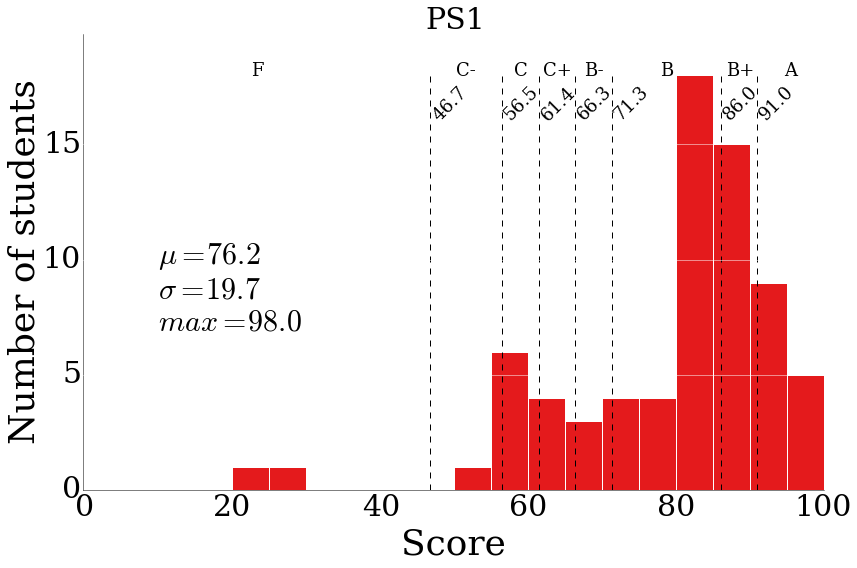

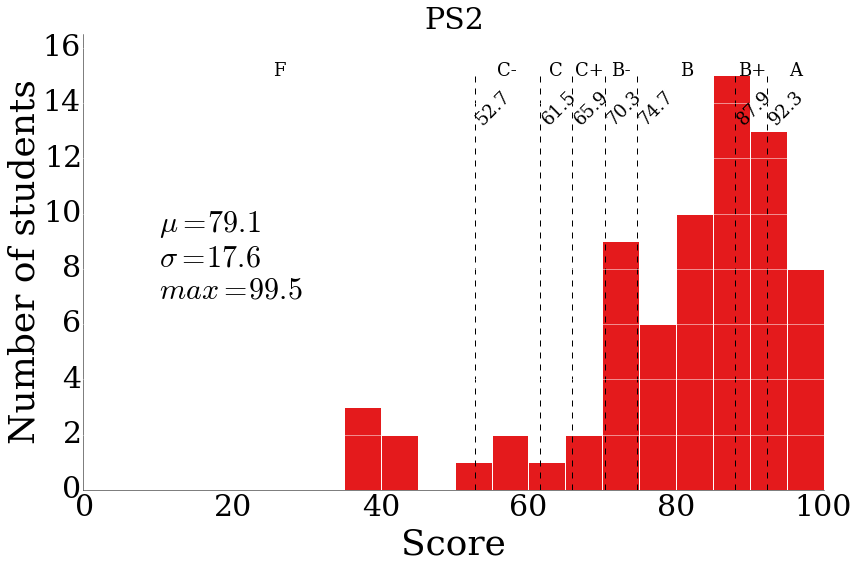

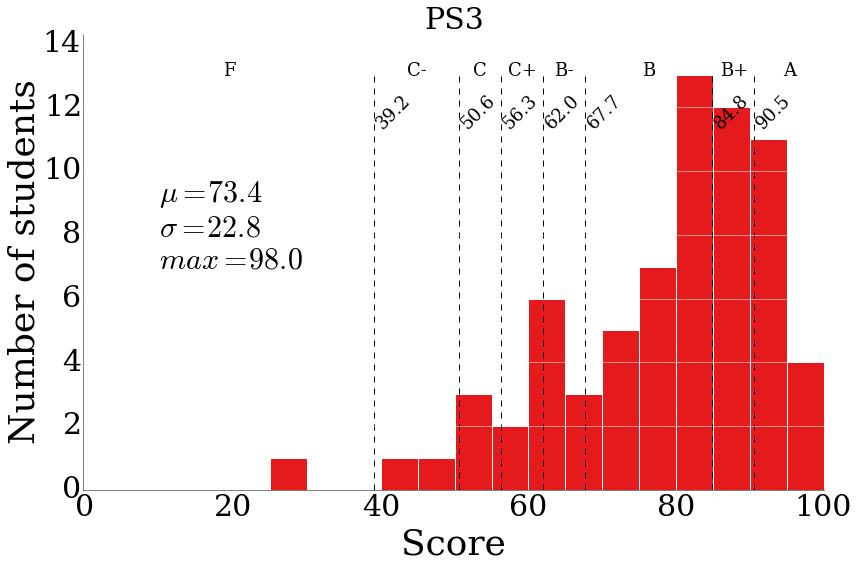

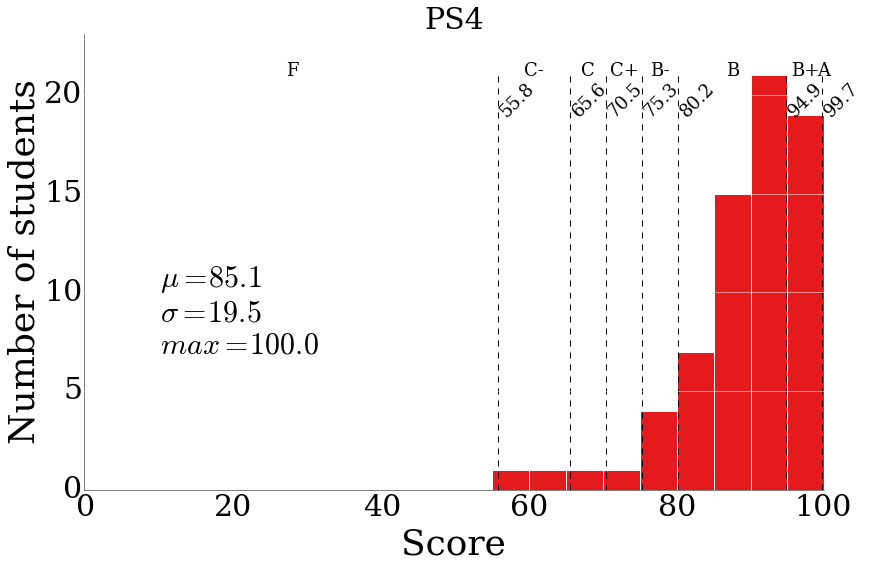

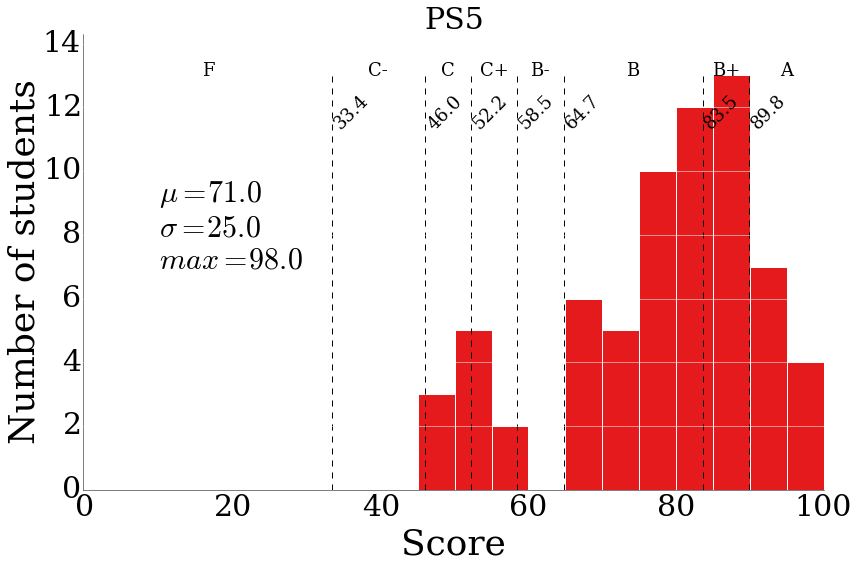

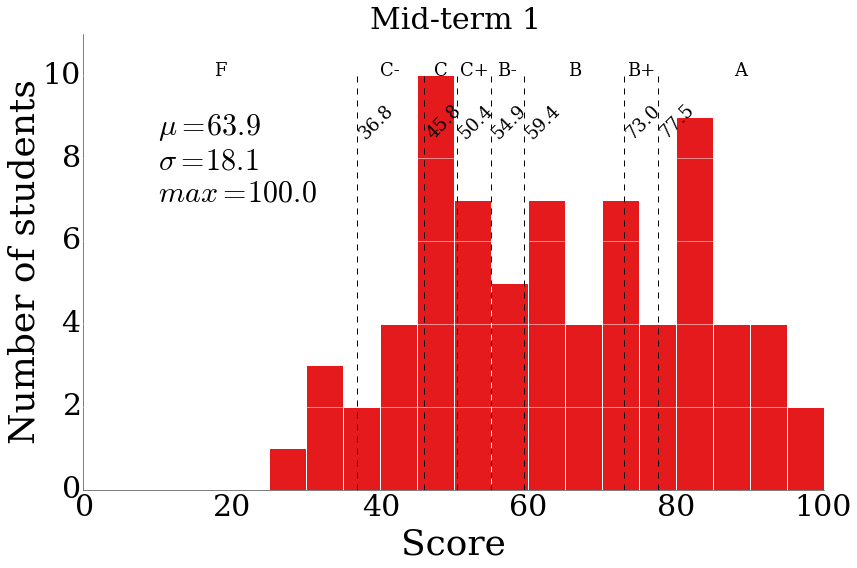

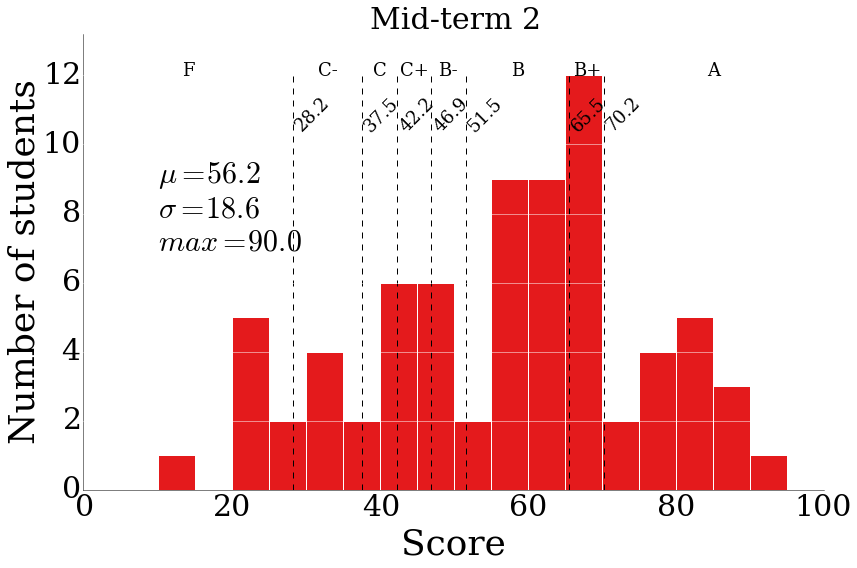

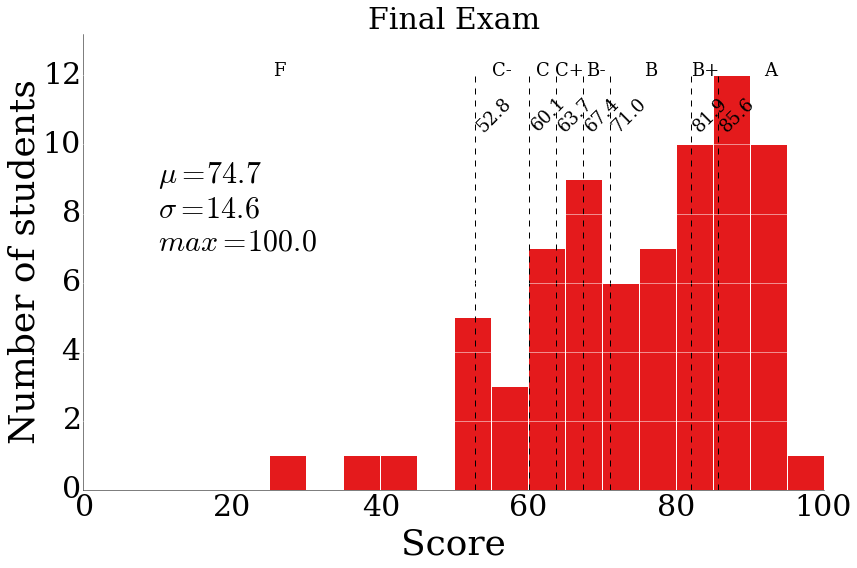

In [5]:
for c in d.columns:
    if "PS" in c or "Mid-term" in c or "Final" in c:
        if not all(np.isnan(d[c])):
            print c
            bar_plot(d, c)

# Overall grade

Overall points and assign overall grade.

Grade A (77.0-100.0): 25
Grade B+ (73.8-77.0): 7
Grade B (64.0-73.8): 18
Grade B- (60.8-64.0): 2
Grade C+ (57.6-60.8): 6
Grade C (54.3-57.6): 6
Grade C- (47.8-54.3): 4
Grade F (0.0-47.8): 5


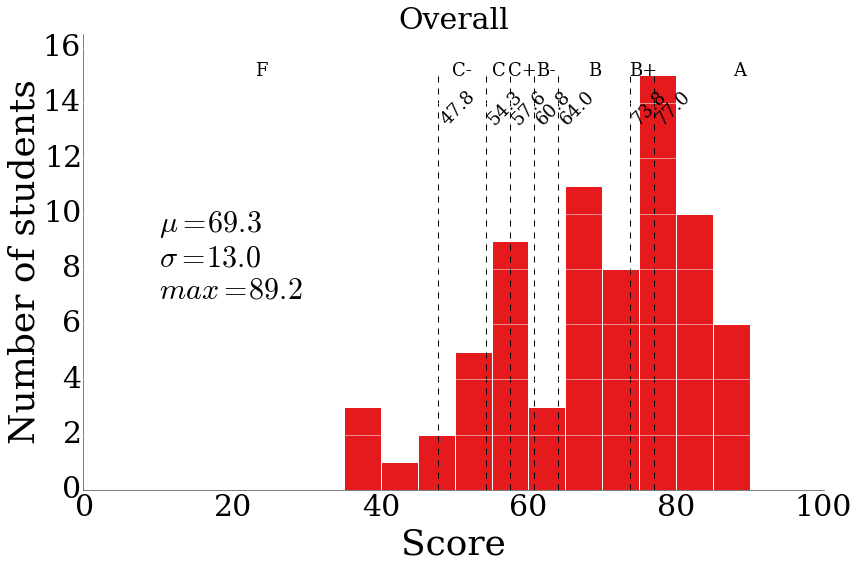

In [6]:
cutoffs = bar_plot(d, "Overall", offset=-2)

In [7]:
def assign_grade(pts):
    for g, c in cutoffs.items():
        if c[0] < pts <= c[1]:
            return g

d["Final_Assigned_Egrade"] = map(assign_grade, d["Overall"])
d.to_csv("Overall grades.csv")